# Simulating catalogs

This tutorial shows how to generate mock catalogs of Galactic binaries

In [9]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

from corner import corner
from fast_lisa_subtraction.utils import latexify

# Specify the device to use for computations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Simulate a DWD Population

We will make use of the `GalacticBinaryPopulation` class to draw samples of a DWD Population.

This class uses enables the sampling of the parameters describing a catalog of GBs

In particular:
- `Frequency`
- `FrequencyDerivative`
- `Amplitude`
- `InitialPhase`
- `Inclination`
- `Polarization`
- `EclipticLatitude`
- `EclipticLongitude`








the the parametrization explained in [De Santi F. et al (2026)](arxiv.XXXX.XXXXX) and is by default initialized to reproduce the best fit to the catalog of [Lamberts A. et al. (2019)](https://academic.oup.com/mnras/article/490/4/5888/5585418)

### Priors

`FastLisaSubtraction` supports multiple analytical priors, like `Uniform`, `Gaussian`, `Gamma`, `LogNormal` as described in [De Santi F. et al (2026)](arxiv.XXXX.XXXXX)

In [10]:
import fast_lisa_subtraction.priors as priors

print(priors.__all__)

['Uniform', 'LogNormal', 'Gamma', 'PowerLaw', 'BrokenPowerLaw', 'UniformCosine', 'UniformSine', 'Gaussian', 'Cauchy', 'GalacticBinaryPopulation']


In order to generate a mock catalog we need to instanciate the `GalacticBinaryPopulation` class.

We first need to define a dictionary with the prior for each set of parameters, as an example:

In [11]:
from fast_lisa_subtraction.priors import *

prior_dict = dict(
                Frequency           = PowerLaw(alpha=-2, minimum=1e-4, maximum=1e-1, name='Frequency', device=device),
                FrequencyDerivative = Gamma(alpha=2, beta=3, offset=-20.0, name='FrequencyDerivative', device=device),
                Amplitude           = LogNormal(mu=-21.5, sigma=0.2, minimum=-24.5, maximum=-20.5, name='Amplitude', device=device),
                InitialPhase        = Uniform(0, 2*np.pi, name='InitialPhase', device=device),
                Inclination         = UniformCosine(0, np.pi, name='Inclination', device=device),
                Polarization        = Uniform(0, 2*np.pi, name='Polarization', device=device),
                EclipticLatitude    = UniformSine(-np.pi/2, np.pi/2, name='EclipticLatitude', device=device),
                EclipticLongitude   = Uniform(0, 2*np.pi, name='EclipticLongitude', device=device)
            )

Then we use the class to sample the marginal and introduce a copula correlation in $f$-$\dot{f}$ as described in [De Santi F. et al (2026)](arxiv.XXXX.XXXXX)

Other available copulas are the `Clayton`, `Frank` and `Student-T`, refer to the documentation page for details

In [ ]:
# Instantiate the GalacticBinaryPopulation class
GB_population = GalacticBinaryPopulation(priors=prior_dict, device=device)

# Generate samples from the population
N = int(1e6)
GB_population_samples = GB_population.sample(N, copula=True, kind='gaussian', rho=0.8)

# Convert to a dataframe and inspect the columns
GB_population_df = GB_population_samples.dataframe()

GB_population_df.head()

   Frequency  FrequencyDerivative     Amplitude  InitialPhase  Inclination  \
0   0.000285         2.105414e-20  1.882924e-23      5.853102     1.606122   
1   0.000095         3.945168e-21  4.589772e-24      3.323740     2.282788   
2   0.000149         7.578036e-21  7.443217e-24      5.664899     2.643346   
3   0.000261         2.306924e-20  3.626446e-23      3.186498     0.987838   
4   0.000298         1.698839e-20  3.076587e-23      5.708230     1.866653   

   Polarization  EclipticLatitude  EclipticLongitude  
0      2.380245          0.448070           2.514156  
1      5.609201          0.417136           3.974519  
2      4.247866          0.195799           1.460894  
3      0.847752          0.816885           1.932063  
4      0.386073          0.729391           6.218767  


In [13]:
GB_population_samples.numpy().shape

(1000000, 8)

We then can plot the distributions

In [14]:
import copy
from fast_lisa_subtraction.utils import latexify

latex_dict = {
    'Frequency': r'$\log_{10}(f/{\rm Hz})$',
    'FrequencyDerivative': r'$\log_{10}\left(\frac{\dot{f}}{{\rm Hzs^{-1}}}\right)$',
    'Amplitude': r'$\log_{10}\mathcal{A}$',
    'InitialPhase': r'$\phi_0$',
    'Inclination': r'$\iota$',
    'Polarization': r'$\psi$',
    'EclipticLatitude': r'$\beta$',
    'EclipticLongitude': r'$\lambda$',
}

@latexify
def plot_catalogue(pop_samples, **corner_kwargs):
    pop_samples = copy.deepcopy(pop_samples)

    for key in ['Frequency', 'FrequencyDerivative', 'Amplitude']:
        pop_samples[key] = copy.deepcopy(torch.log10(pop_samples[key]))
    
    pop_samples_numpy = pop_samples.numpy()
    latex_labels = [latex_dict[key] for key in pop_samples.keys()]
    
    return corner(pop_samples_numpy, labels=latex_labels, **corner_kwargs)

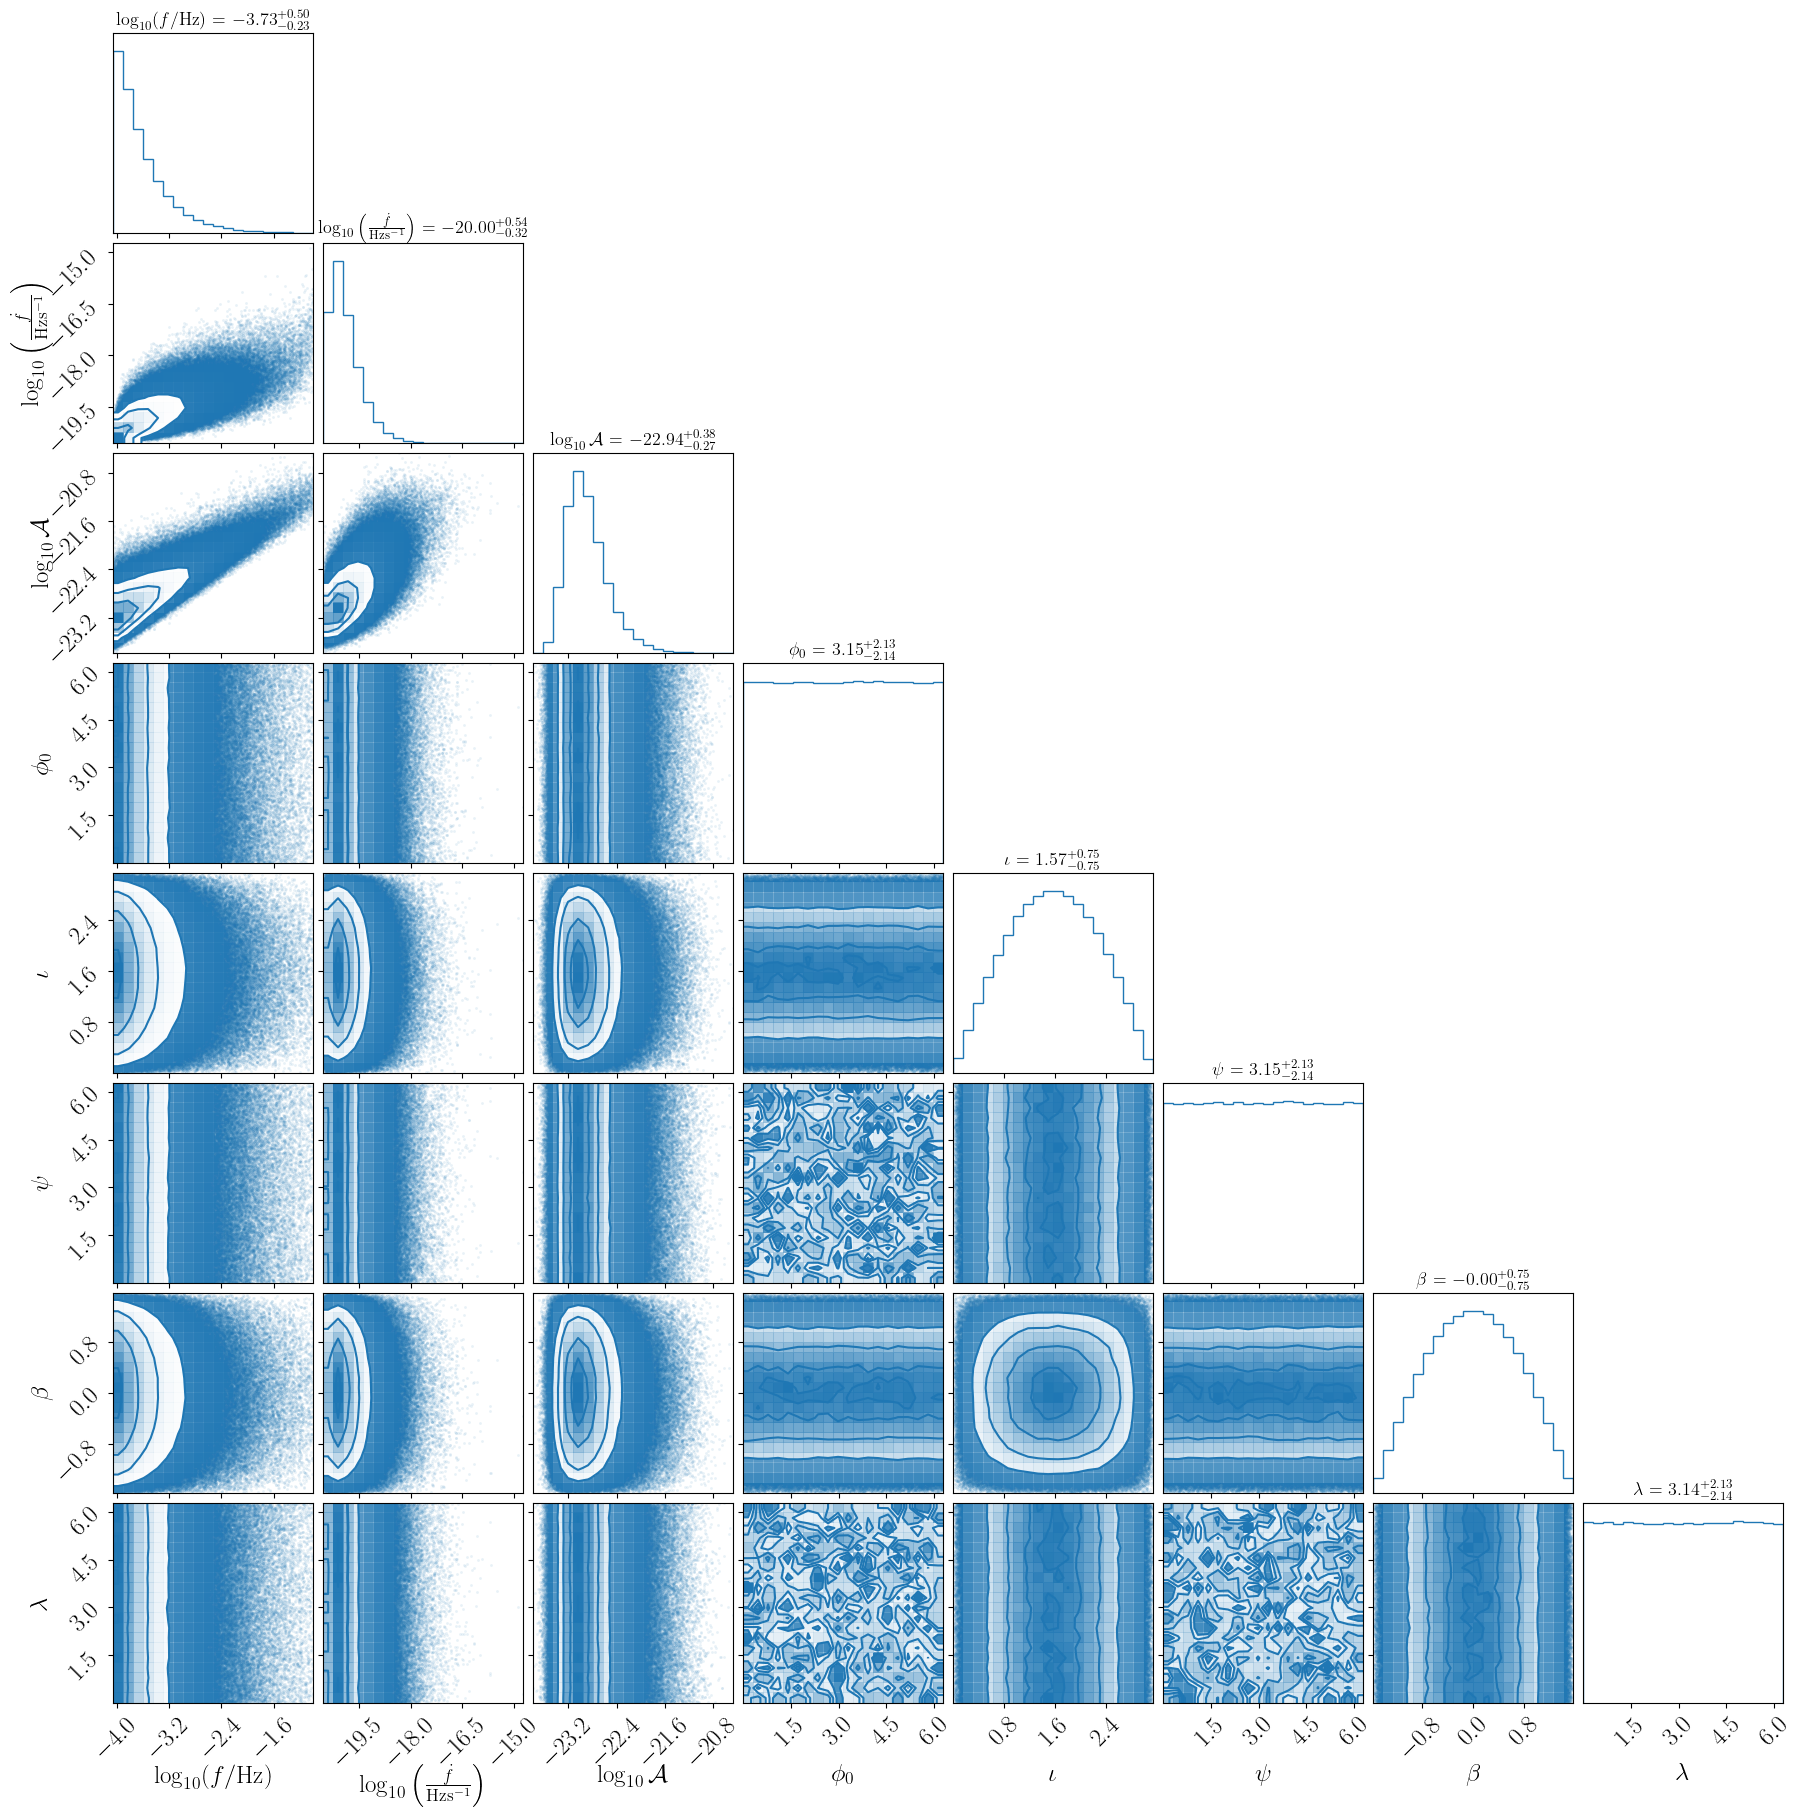

In [15]:
fig = plot_catalogue(GB_population_samples, color='C0', plot_datapoints=True, show_titles=True, title_kwargs={'fontsize': 13})

The class is by default initialized to reproduce the best fit to the catalog of [Lamberts A. et al. (2019)](https://academic.oup.com/mnras/article/490/4/5888/5585418).

[WARNING] - Too few points to create valid contours


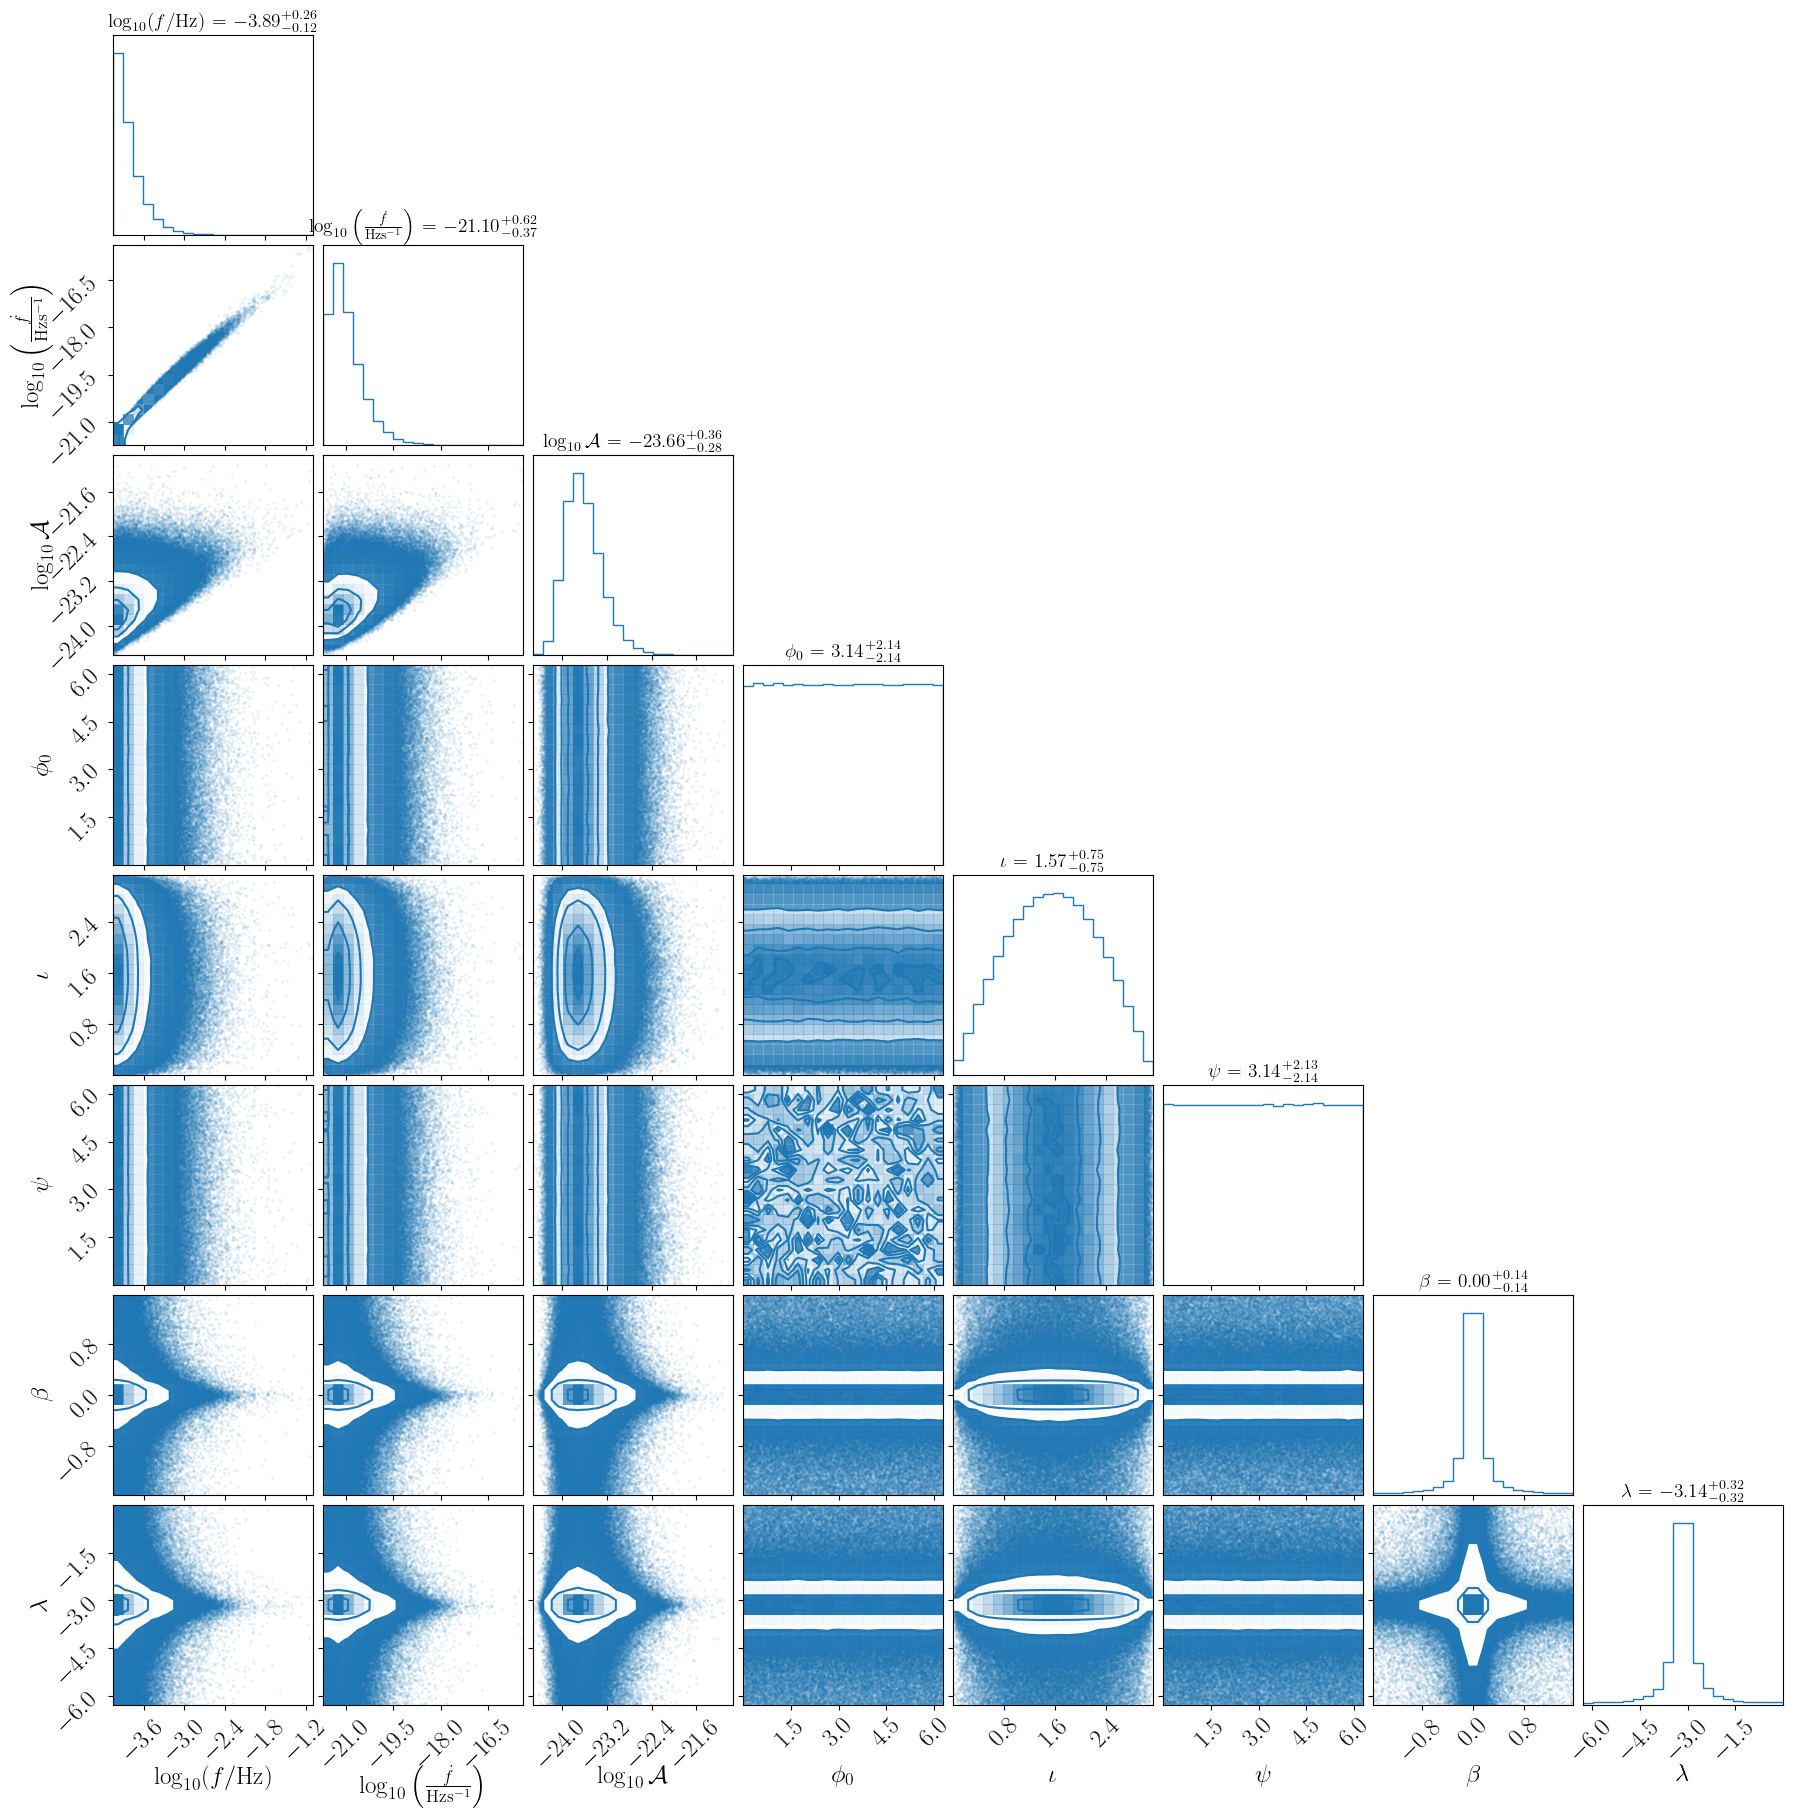

In [16]:
# Instantiate the GalacticBinaryPopulation class
GB_population = GalacticBinaryPopulation(device=device)

# Generate samples from the population
GB_population_samples = GB_population.sample(N, copula=True, kind='gaussian', rho=0.995)

# Convert to a dataframe and inspect the columns
GB_population_df = GB_population_samples.dataframe()

fig = plot_catalogue(GB_population_samples, color='C0', plot_datapoints=True, show_titles=True, title_kwargs={'fontsize': 14})